# AlphaZero

This notebook is based on the paper:

* [Mastering the game of Go without Human Knowledge](https://deepmind.com/research/publications/mastering-game-go-without-human-knowledge/)

with additional insight from:

* https://applied-data.science/blog/how-to-build-your-own-alphazero-ai-using-python-and-keras/
* https://github.com/AppliedDataSciencePartners/DeepReinforcementLearning


This code use the new [conx](http://conx.readthedocs.io/en/latest/) layer that sits on top of Keras. Conx is designed to be simpler than Keras, more intuitive, and integrated visualizations.

Currently this code requires the TensorFlow backend, as it has a function specific to TF.

## The Game

First, let's look at a specific game. We can use many, but for this demonstration we'll pick ConnectFour. There is a good code base of different games and a game engine in the [code](https://github.com/Calysto/aima3/) based on [Artificial Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/).

If you would like to install aima3, you can use something like this in a cell:

```bash
! pip install aima3 -U --user
```
aima3 has other games that you can play as well as ConnectFour, including TicTacToe.

aima3 has many AI algorithms wrapped up to play games. We import some of them:

In [1]:
from aima3.games import (ConnectFour, RandomPlayer, 
                         MCTSPlayer, QueryPlayer, Player,
                         MiniMaxPlayer, AlphaBetaPlayer,
                         AlphaBetaCutoffPlayer)
import numpy as np

Let's make a game:

In [2]:
game = ConnectFour()

and play a game between two random players:

In [3]:
game.play_game(RandomPlayer("Random-1"), RandomPlayer("Random-2"))

Random-2 is thinking...
Random-2 makes action (2, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . . . . . 
Random-1 is thinking...
Random-1 makes action (2, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. O . . . . . 
. X . . . . . 
Random-2 is thinking...
Random-2 makes action (2, 3):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . . . . . 
. O . . . . . 
. X . . . . . 
Random-1 is thinking...
Random-1 makes action (5, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . . . . . 
. O . . . . . 
. X . . O . . 
Random-2 is thinking...
Random-2 makes action (6, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . . . . . 
. O . . . . . 
. X . . O X . 
Random-1 is thinking...
Random-1 makes action (7, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . . . . . 
. O . . . . . 
. X . . O X O 
Random-2 is thinking...
Random-2 makes action 

['Random-2']

We can also play a match (a bunch of games) or even a tournament between a bunch of players.

```python
p1 = RandomPlayer("Random-1")
p2 = MiniMax("MiniMax-1")
p3 = AlphaBetaCutoff("ABCutoff-1")

game.play_matches(10, p1, p2)

game.tournament(1, p1, p2, p3)
```

Can you beat RandomPlayer? Hope so!

Can you beat MiniMax? No! But it takes too long.

Humans enter their commands by (column, row) where column starts at 1 from left, and row starts at 1 from bottom.

In [188]:
game.play_game(AlphaBetaCutoffPlayer("AlphaBetaCutoff"), QueryPlayer("Doug"))

AlphaBetaCutoff is thinking...
AlphaBetaCutoff makes action (1, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . . . . . . 
Doug is thinking...
current state:
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . . . . . . 
available moves: [(1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

Your move? 2,1
Doug makes action (2, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X O . . . . . 
AlphaBetaCutoff is thinking...
AlphaBetaCutoff makes action (1, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . . . . . . 
X O . . . . . 
Doug is thinking...
current state:
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . . . . . . 
X O . . . . . 
available moves: [(1, 3), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

Your move? 1,3
Doug makes action (1, 3):
. . . . . . . 
. . . . . . . 
. . . .

['AlphaBetaCutoff']

## The Network

Net, we are going to build the same kind of network described in the AlphaZero paper.

Make sure to set your Keras backend to TensorFlow for now, as we have a function that is written at that level.

In [4]:
import conx as cx
from keras import regularizers

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
conx, version 3.5.12


In [5]:
def add_conv_layer(net, input_layer):
    cname = net.add(cx.Conv2DLayer("conv2d-%d", 
                    filters=75, 
                    kernel_size=(4,4), 
                    padding='same', 
                    use_bias=False,
                    activation='linear', 
                    kernel_regularizer=regularizers.l2(0.0001)))
    bname = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    lname = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    net.connect(input_layer, cname)
    net.connect(cname, bname)
    net.connect(bname, lname)
    return lname

def add_residual_layer(net, input_layer):
    prev_layer = add_conv_layer(net, input_layer)
    cname = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=75,
        kernel_size=(4,4),
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    bname = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    aname = net.add(cx.AddLayer("add-%d"))
    lname = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    net.connect(prev_layer, cname)
    net.connect(cname, bname)
    net.connect(input_layer, aname)
    net.connect(bname, aname)
    net.connect(aname, lname)
    return lname

def add_value_head(net, input_layer):
    l1 = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=1,
        kernel_size=(1,1),
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    l2 = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    l3 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l4 = net.add(cx.FlattenLayer("flatten-%d"))
    l5 = net.add(cx.Layer("dense-%d",
        20,
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    l6 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l7 = net.add(cx.Layer('value_head',
        1,
        use_bias=False,
        activation='tanh',
        kernel_regularizer=regularizers.l2(0.0001)))
    net.connect(input_layer, l1)
    net.connect(l1, l2)
    net.connect(l2, l3)
    net.connect(l3, l4)
    net.connect(l4, l5)
    net.connect(l5, l6)
    net.connect(l6, l7)
    return l7

def add_policy_head(net, input_layer):
    l1 = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=2,
        kernel_size=(1,1),
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer = regularizers.l2(0.0001)))
    l2 = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    l3 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l4 = net.add(cx.FlattenLayer("flatten-%d"))
    l5 = net.add(cx.Layer('policy_head',
            42,
            use_bias=False,
            activation='linear',
            kernel_regularizer=regularizers.l2(0.0001)))
    net.connect(input_layer, l1)
    net.connect(l1, l2)
    net.connect(l2, l3)
    net.connect(l3, l4)
    net.connect(l4, l5)
    return l5

In [6]:
def make_network(residuals=5):
    net = cx.Network("Residual CNN")
    net.add(cx.Layer("main_input", (game.v, game.h, 2)))
    out_layer = add_conv_layer(net, "main_input")
    for i in range(residuals):
        out_layer = add_residual_layer(net, out_layer)
    add_policy_head(net, out_layer)
    add_value_head(net, out_layer)
    net.compile(loss={'value_head': 'mean_squared_error', 
                  'policy_head': softmax_cross_entropy_with_logits},
            optimizer=cx.SGD(lr=0.1, momentum=0.9),
            loss_weights={'value_head': 0.5, 
                          'policy_head': 0.5})
    return net

In [7]:
## NEED TO REWRITE THIS FUNCTION IN KERAS:

import tensorflow as tf

def softmax_cross_entropy_with_logits(y_true, y_pred):
    p = y_pred
    pi = y_true
    zero = tf.zeros(shape = tf.shape(pi), dtype=tf.float32)
    where = tf.equal(pi, zero)
    negatives = tf.fill(tf.shape(pi), -100.0) 
    p = tf.where(where, negatives, p)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels = pi, logits = p)
    return loss

In [8]:
net = make_network()

In [9]:
net.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 6, 7, 2)      0                                            
__________________________________________________________________________________________________
conv2d-1 (Conv2D)               (None, 6, 7, 75)     2400        main_input[0][0]                 
__________________________________________________________________________________________________
batch-norm-1 (BatchNormalizatio (None, 6, 7, 75)     24          conv2d-1[0][0]                   
__________________________________________________________________________________________________
leaky-relu-1 (LeakyReLU)        (None, 6, 7, 75)     0           batch-norm-1[0][0]               
__________________________________________________________________________________________________
conv2d-2 (

In [9]:
len(net.layers)

51

<IPython.core.display.Javascript object>


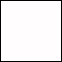
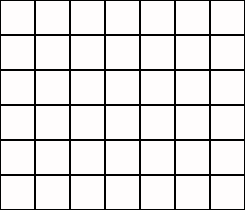
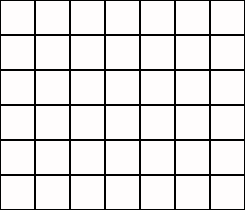
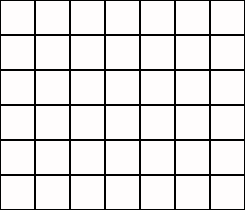
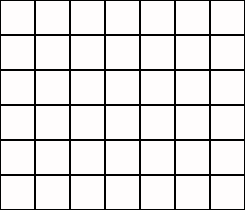
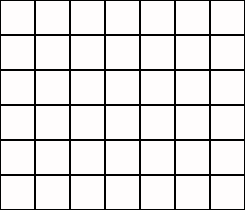
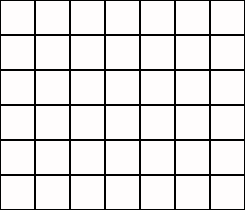
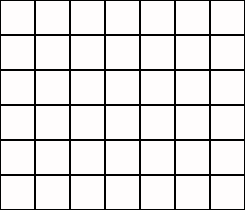
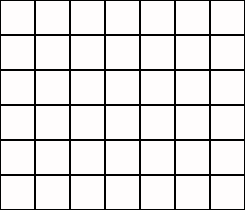
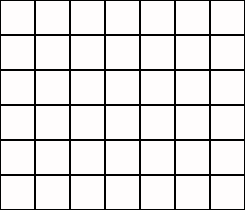
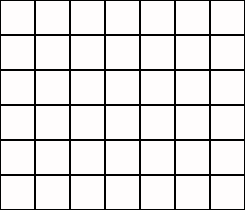
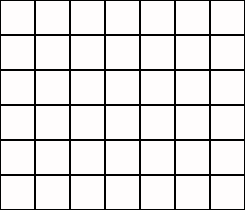
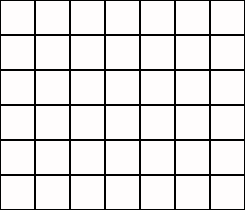
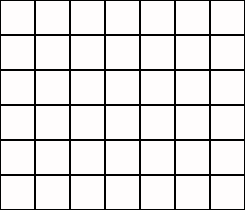
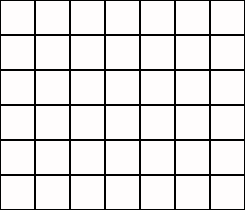
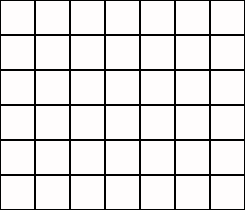
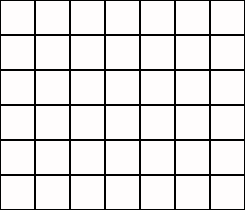
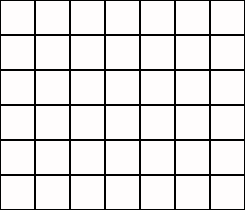
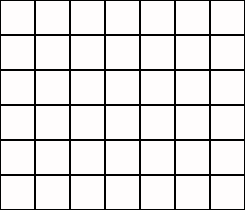
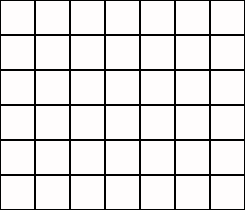
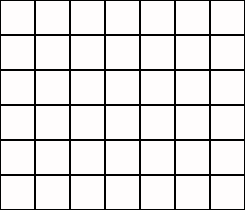
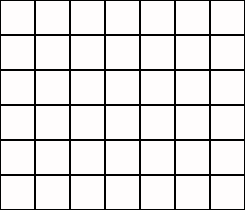
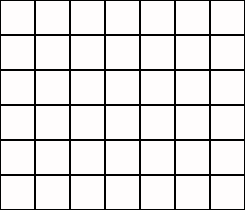
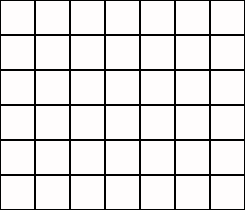
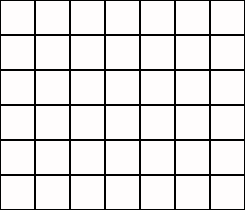
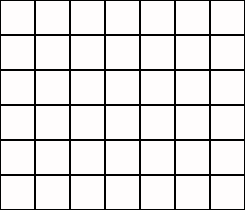
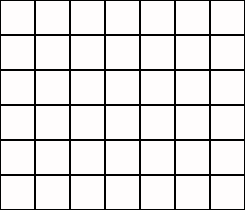
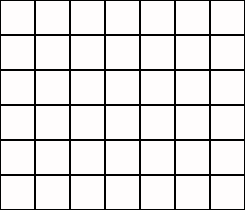
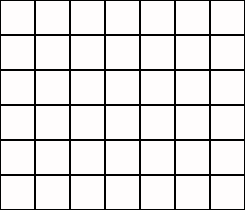
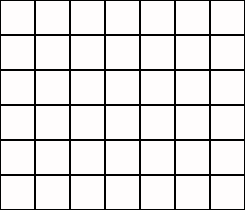
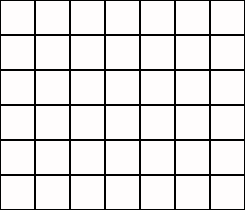
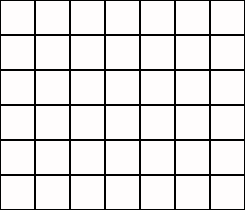
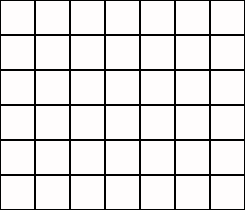
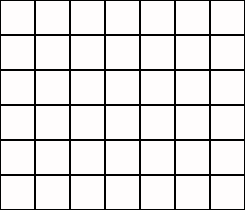
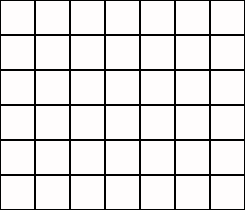
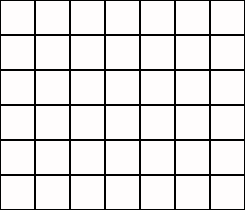
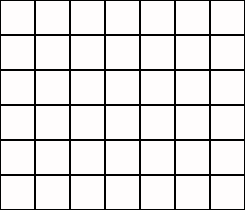
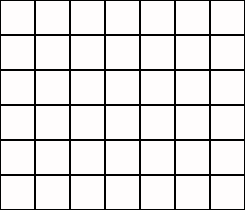
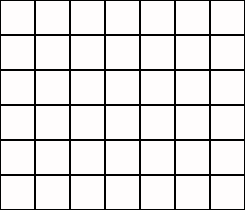
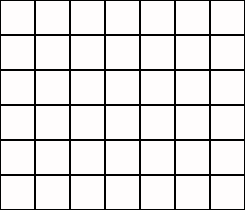
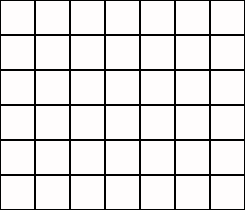
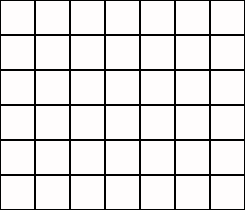
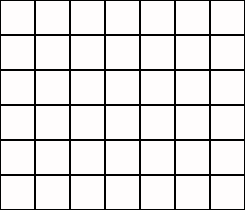
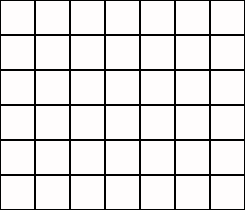
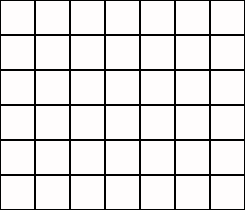
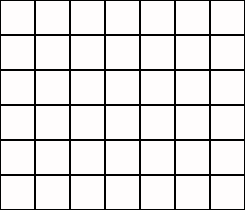

In [240]:
net.render(height="15000px")

## Connecting the Network to the Game

First, we need a mapping from game (x,y) moves to a position in a list of actions and probabilities.

In [10]:
def make_mappings(game):
    """
    Get a mapping from game's (x,y) to array position.
    """
    move2pos = {}
    pos2move = []
    position = 0
    for y in range(game.v, 0, -1):
        for x in range(1, game.h + 1):
            move2pos[(x,y)] = position
            pos2move.append((x,y))
            position += 1
    return move2pos, pos2move

We use the connectFour game, defined above:

In [11]:
move2pos, pos2move = make_mappings(game)

In [12]:
move2pos[(2,1)]

36

In [13]:
pos2move[35]

(1, 1)

Need a method of converting a list of state moves into an array:

In [14]:
def state2array(game, state):
    array = []
    to_move = game.to_move(state)
    for y in range(game.v, 0, -1):
        for x in range(1, game.h + 1):
            item = state.board.get((x, y), 0)
            if item != 0:
                item = 1 if item == to_move else -1
            array.append(item)
    return array

In [15]:
cx.shape(state2array(game, game.initial))

(42,)

In [16]:
def state2inputs(game, state):
    board = np.array(state2array(game, state)) # 1 is my pieces, -1 other
    currentplayer_position = np.zeros(len(board), dtype=np.int)
    currentplayer_position[board==1] = 1
    other_position = np.zeros(len(board), dtype=np.int)
    other_position[board==-1] = 1
    position = np.array(list(zip(currentplayer_position,other_position)))
    inputs = position.reshape((game.v, game.h, 2))
    return inputs.tolist()

In [17]:
state2inputs(game, game.initial)

[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]

Feature 0,Feature 1

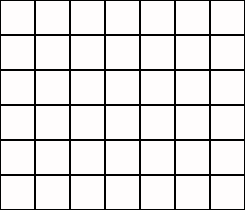
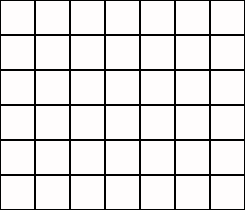

In [18]:
state = game.initial
net.propagate_to_features("main_input", state2inputs(game, state))

Feature 0,Feature 1

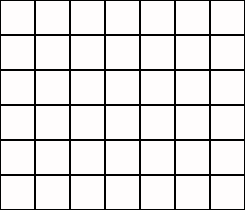
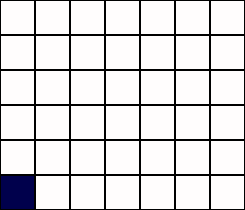

In [19]:
state = game.result(game.initial, (1,1))
net.propagate_to_features("main_input", state2inputs(game, state))

Feature 0,Feature 1

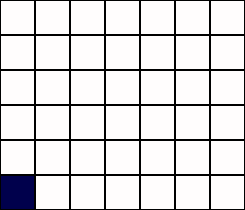
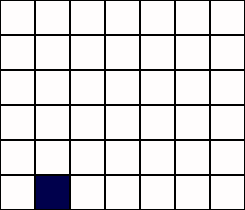

In [20]:
state = game.result(state, (2,1))
net.propagate_to_features("main_input", state2inputs(game, state))

Finally, we are ready to connect the game to the network. We define a function `get_predictions` that takes a game and state, and propagates it through the network returning a (value, probabilities, allowedActions). The probabilities are the pi list from the AlphaZero paper.

In [21]:
def get_predictions(net, game, state):
    """
    Given a state, give output of network on preferred
    actions. state.allowedActions removes impossible
    actions.

    Returns (value, probabilties, allowedActions)
    """
    board = np.array(state2array(game, state)) # 1 is my pieces, -1 other
    inputs = state2inputs(game, state)
    preds = net.propagate(inputs, visualize=True)
    value = preds[1][0]
    logits = np.array(preds[0])
    allowedActions = np.array([move2pos[act] for act in game.actions(state)])
    mask = np.ones(len(board), dtype=bool)
    mask[allowedActions] = False
    logits[mask] = -100
    #SOFTMAX
    odds = np.exp(logits)
    probs = odds / np.sum(odds) ###put this just before the for?
    return (value, probs.tolist(), allowedActions.tolist())

In [22]:
value, probs, acts = get_predictions(net, game, state)

<IPython.core.display.Javascript object>


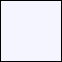
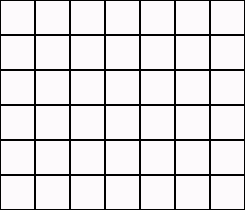
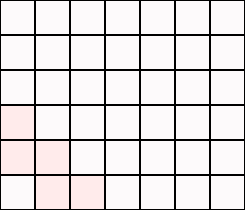
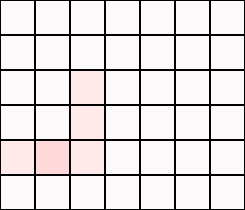
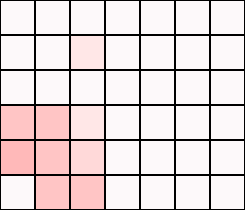
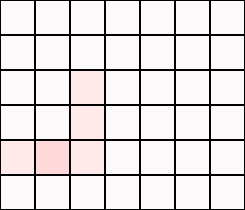
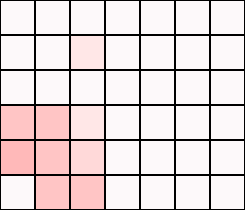
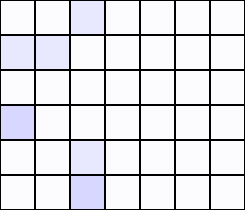
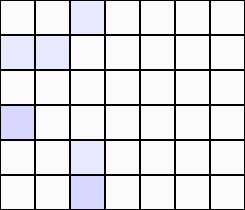
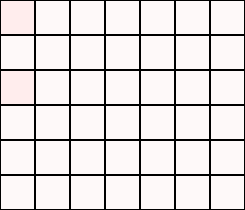
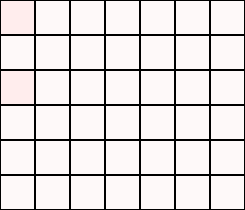
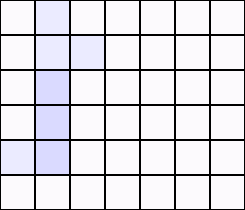
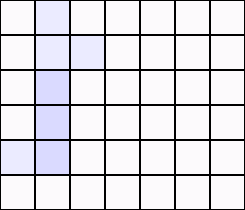
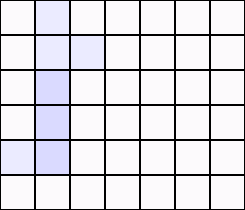
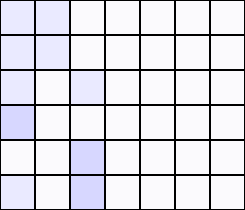
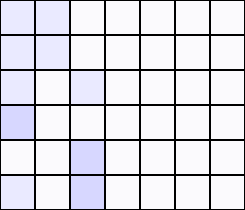
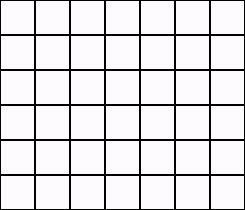
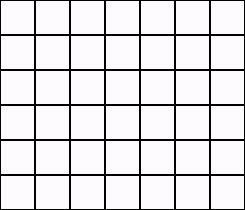
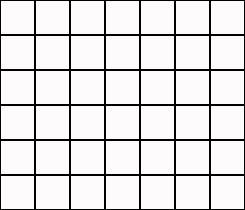
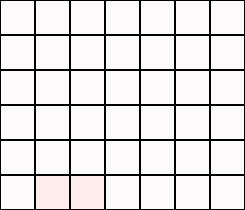
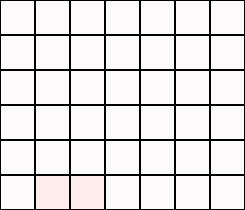
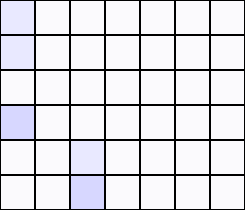
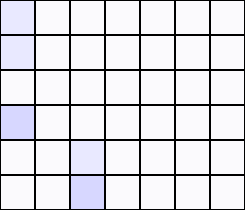
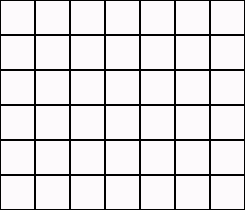
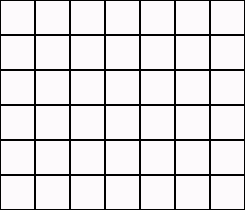
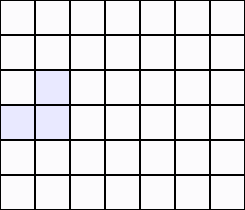
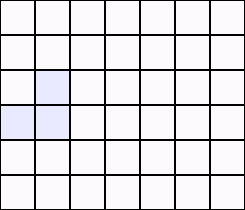
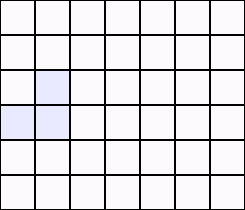
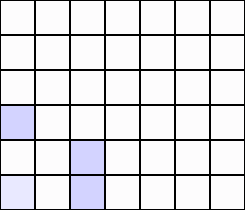
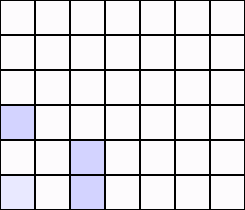
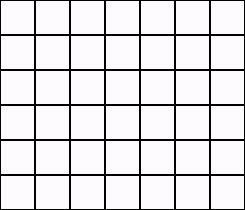
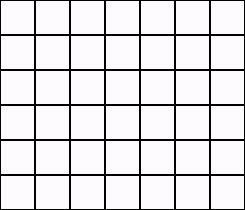
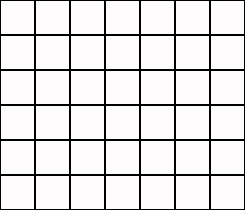
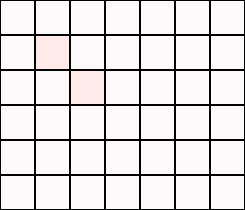
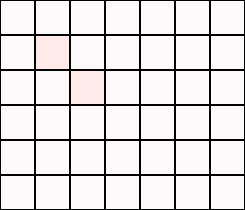
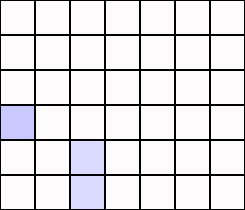
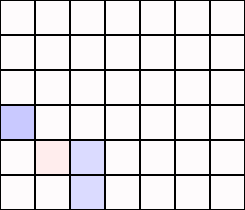
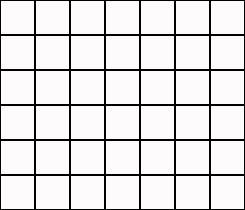
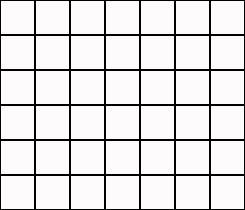
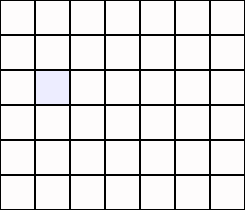
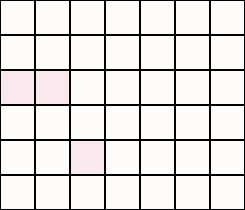
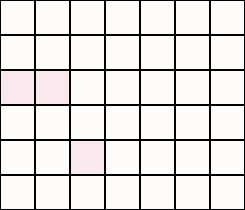
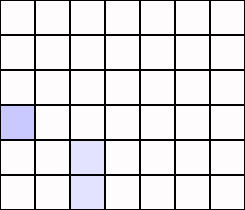
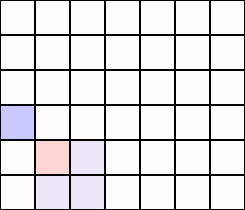
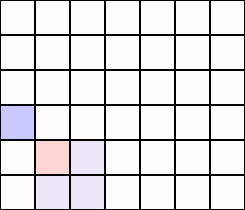
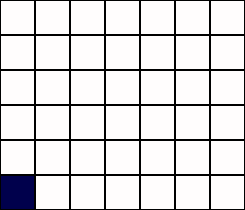

In [23]:
net.snapshot(state2inputs(game, state), height="15000px")

## Testing Game and Network Integration

In [24]:
game = ConnectFour()
p1 = QueryPlayer("Doug")
p2 = RandomPlayer("Rando")
p1.set_game(game)
p2.set_game(game)
state = game.initial
turn = 1

In [25]:
move = p2.get_action(state, turn)
move

(1, 1)

In [26]:
state = game.result(state, move)

In [27]:
move = p1.get_action(state, turn)
move

current state:
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . . . . . . 
available moves: [(1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

Your move? 1,2


(1, 2)

In [28]:
state = game.result(state, move)

In [29]:
turn += 1

In [30]:
game.display(state)

. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
O . . . . . . 
X . . . . . . 


In [31]:
value, probs, acts = get_predictions(net, game, state)

Finally, we turn the predictions into a move, and we can play a game with the network.

In [32]:
class NNPlayer(Player):

    def set_game(self, game):
        """
        Get a mapping from game's (x,y) to array position.
        """
        self.net = make_network()
        self.game = game
        self.move2pos = {}
        self.pos2move = []
        position = 0
        for y in range(self.game.v, 0, -1):
            for x in range(1, self.game.h + 1):
                self.move2pos[(x,y)] = position
                self.pos2move.append((x,y))
                position += 1

    def get_predictions(self, state):
        """
        Given a state, give output of network on preferred
        actions. state.allowedActions removes impossible
        actions.

        Returns (value, probabilties, allowedActions)
        """
        board = np.array(self.state2array(state)) # 1 is my pieces, -1 other
        inputs = self.state2inputs(state)
        preds = self.net.propagate(inputs)
        value = preds[1][0]
        logits = np.array(preds[0])
        allowedActions = np.array([self.move2pos[act] for act in self.game.actions(state)])
        mask = np.ones(len(board), dtype=bool)
        mask[allowedActions] = False
        logits[mask] = -100
        #SOFTMAX
        odds = np.exp(logits)
        probs = odds / np.sum(odds) 
        return (value, probs.tolist(), allowedActions.tolist())
    
    def get_action(self, state, turn):
        value, probabilities, moves = self.get_predictions(state)
        probs = np.array(probabilities)[moves]
        pos = cx.choice(moves, probs)
        return self.pos2move[pos]

    def state2inputs(self, state):
        board = np.array(self.state2array(state)) # 1 is my pieces, -1 other
        currentplayer_position = np.zeros(len(board), dtype=np.int)
        currentplayer_position[board==1] = 1
        other_position = np.zeros(len(board), dtype=np.int)
        other_position[board==-1] = 1
        position = np.array(list(zip(currentplayer_position,other_position)))
        inputs = position.reshape((self.game.v, self.game.h, 2))
        return inputs

    def state2array(self, state):
        array = []
        to_move = self.game.to_move(state)
        for y in range(self.game.v, 0, -1):
            for x in range(1, self.game.h + 1):
                item = state.board.get((x, y), 0)
                if item != 0:
                    item = 1 if item == to_move else -1
                array.append(item)
        return array

In [33]:
p3 = NNPlayer("AlphaZero")

In [34]:
p3.set_game(game)

In [35]:
p3.get_action(state, 2)

(6, 1)

In [36]:
game.play_game(p2, p3)

AlphaZero is thinking...
AlphaZero makes action (7, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . X 
Rando is thinking...
Rando makes action (6, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . O X 
AlphaZero is thinking...
AlphaZero makes action (3, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . X . . O X 
Rando is thinking...
Rando makes action (3, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . O . . . . 
. . X . . O X 
AlphaZero is thinking...
AlphaZero makes action (2, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . O . . . . 
. X X . . O X 
Rando is thinking...
Rando makes action (7, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . O . . . O 
. X X . . O X 
AlphaZero is thinking...
AlphaZero makes action (4, 1):
. 

['AlphaZero']

## Training The Network

**THIS IS WORK IN PROGRESS**

Now we are ready to train the network. The training is a clever use of Monte Carlo Tree Search.

There is a Monte Carlo Tree Search player that we will use:

In [37]:
p4 = MCTSPlayer("Monte")

In [38]:
p4.set_game(game)

With this player, we can give an additional argument, `return_prob`, that will return the probabilities found for each possible move:

In [39]:
move, pi = p4.get_action(game.initial, turn=1, return_prob=True)
pi

{(1, 1): 0.19862223463025433,
 (2, 1): 0.19862223463025433,
 (3, 1): 0.19862223463025433,
 (4, 1): 0.19862223463025433,
 (5, 1): 0.19862223463025433,
 (6, 1): 0.003444413424364144,
 (7, 1): 0.003444413424364144}

Every time you run that line, you will get different probabilities. We will use these probabilities to train the network. However, another clever twist is that we will have two networks, playing each other.

In [40]:
currentPlayer = NNPlayer("Current Player")
bestPlayer = NNPlayer("Best Player")

In [41]:
game = ConnectFour()
player = MCTSPlayer("Training Player")
player.set_game(game)
state = game.initial

In [42]:
player.get_action(state, 1, True)

((1, 1),
 {(1, 1): 0.19862223463025433,
  (2, 1): 0.19862223463025433,
  (3, 1): 0.19862223463025433,
  (4, 1): 0.19862223463025433,
  (5, 1): 0.19862223463025433,
  (6, 1): 0.003444413424364144,
  (7, 1): 0.003444413424364144})

In [43]:
class NNTrainer(MCTSPlayer):
    ## Load weights if continuing
    def set_game(self, game):
        super().set_game(game)
        self.nnplayer = NNPlayer("NNPlayer")
        self.nnplayer.set_game(game)
    
    def policy(self, game, state):
        # these moves are positions:
        value, probs_all, moves = self.nnplayer.get_predictions(state)
        if len(moves) == 0:
            result = [], value
        else:
            probs = np.array(probs_all)[moves]
            moves = [self.nnplayer.pos2move[pos] for pos in moves]
            # we need to return probs and moves for game
            result = [(act, prob) for (act, prob) in list(zip(moves, probs))], value
        return result

In [44]:
p1 = NNTrainer("NNTrainer")
p2 = RandomPlayer("Random")

In [45]:
game.play_game(p1, p2)

NNTrainer is thinking...
NNTrainer makes action (4, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . X . . . 
Random is thinking...
Random makes action (5, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . X O . . 
NNTrainer is thinking...
NNTrainer makes action (2, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . X O . . 
Random is thinking...
Random makes action (4, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . O . . . 
. X . X O . . 
NNTrainer is thinking...
NNTrainer makes action (3, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . O . . . 
. X X X O . . 
Random is thinking...
Random makes action (3, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . O O . . . 
. X X X O . . 
NNTrainer is thinking...
NNTrainer makes action (1, 

['NNTrainer']

In [46]:
def move_probs2all_probs(game, move_probs):
    all_probs = np.zeros(len(state2array(game, game.initial)))
    for move in move_probs:
        all_probs[move2pos[move]] = move_probs[move]
    return all_probs.tolist()

def collect_data():
    game = ConnectFour()
    current_NN = NNTrainer("NNTrainer")
    best_NN = NNTrainer("NNTrainer")
    current_NN.set_game(game)
    best_NN.set_game(game)
    state = game.initial
    turn = 1
    counter = 0
    players = [best_NN, current_NN]
    data = [[], []]
    while not game.terminal_test(state):
        game = players[counter % 2].game
        move, pi = players[counter % 2].get_action(state, round(turn), return_prob=True)
        value = game.utility(state, game.to_move(state))
        data[counter % 2].append([state2inputs(game, state), [move_probs2all_probs(game, pi), [value]]])
        state = game.result(state, move)
        turn += 0.5
        counter += 1
    return data

In [47]:
data = collect_data()

In [48]:
len(data[0]), len(data[1])

(9, 8)

In [49]:
net.dataset.load(data[0])

In [50]:
net.train_one(data[0][0][0], data[0][0][1])

([[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0]],
 [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   -0.003444413424364144,
   -0.19862223463025433,
   -0.19862223463025433,
   -0.19862223463025433,
   -0.19862223463025433,
   -0.19862223463025433,
   -0.003444413424364144],
  [0.0]])

## Summary

* Play against itself, at just the right level. Evolution-style.
* Uses search in training.